# E-commerce 


Целью данного проекта является анализ совершенных покупок сервиса для ответа на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?
2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
3. По каждому товару определить, в какой день недели товар чаще всего покупается.
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
5. Провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.
6. Построить RFM-сегментацию пользователей.

### Данные

1. olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
- customer_id — позаказный идентификатор пользователя
- customer_unique_id — уникальный идентификатор пользователя (аналог номера паспорта)
- customer_zip_code_prefix — почтовый индекс пользователя
- customer_city — город доставки пользователя
- customer_state — штат доставки пользователя

2. olist_orders_dataset.csv — таблица заказов
- order_id — уникальный идентификатор заказа (номер чека)
- customer_id — позаказный идентификатор пользователя
- order_status — статус заказа
- order_purchase_timestamp — время создания заказа
- order_approved_at — время подтверждения оплаты заказа
- order_delivered_carrier_date — время передачи заказа в логистическую службу
- order_delivered_customer_date — время доставки заказа
- order_estimated_delivery_date — обещанная дата доставки

3. olist_order_items_dataset.csv — товарные позиции, входящие в заказы
- order_id — уникальный идентификатор заказа (номер чека)
- order_item_id — идентификатор товара внутри одного заказа
- product_id — идентификатор товара (аналог штрихкода)
- seller_id — идентификатор производителя товара
- shipping_limit_date — максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- price — цена за единицу товара
- freight_value — вес товара

Уникальные статусы заказов в таблице olist_orders_dataset:

- created — создан
- approved — подтверждён
- invoiced — выставлен счёт
- processing — в процессе сборки заказа
- shipped — отгружен со склада
- delivered — доставлен пользователю
- unavailable — недоступен
- canceled — отменён

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil


In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')

In [3]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Посмотрим на типы данных, произведем необходимую предобработку для дальнейшего анализа

In [6]:
customers.dtypes 

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [7]:
items.dtypes #столбцы с датами записаны в неверном формате

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [8]:
orders.dtypes  #столбцы с датами записаны в неверном формате

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [9]:
# исправим формат колонок с датой с object на datetime
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp)
orders.order_approved_at  = pd.to_datetime(orders.order_approved_at)
orders.order_delivered_carrier_date  = pd.to_datetime(orders.order_delivered_carrier_date)
orders.order_delivered_customer_date  = pd.to_datetime(orders.order_delivered_customer_date)
orders.order_estimated_delivery_date  = pd.to_datetime(orders.order_estimated_delivery_date)

items.shipping_limit_date = pd.to_datetime(items.shipping_limit_date)

In [10]:
customers.isna().sum() #нет пропущенных значений
orders.isna().sum() #пропущенные значения в столбцах order_approved_at, order_delivered_carrier_date,order_delivered_customer_date обозначены струтурой датафрема - дата пустая если действие не произошло
items.isna().sum() #нет пропущенных значений

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

### 1. Сколько у нас пользователей, которые совершили покупку только один раз?
Покупкой будем считать не отмененные и оплаченные заказы.

In [11]:
customers\
    .merge(orders, on = 'customer_id') \
    .query('order_status != "canceled" and order_approved_at.isnull() == False')\
    .groupby('customer_unique_id', as_index = False) \
    .agg({'order_id' : 'count'}) \
    .query('order_id == 1').shape[0]

92621

92621 пользователей совершили покупку один раз

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Недоставленными будем считать заказы, у которых время доставки заказа (order_delivered_customer_date) пустое и заказ  имеет статус "отменен" или "недоступен", так как только это может быть причиной того, что заказы не были доставлены

In [12]:
undelivered_orders = orders.query('(order_status == "canceled" or order_status == "unavailable") and order_delivered_customer_date.isna()')
undelivered_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05
...,...,...,...,...,...,...,...,...
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [13]:
undelivered_orders.order_purchase_timestamp = undelivered_orders.order_purchase_timestamp.dt.to_period('M')
undelivered_orders\
    .groupby(['order_purchase_timestamp', 'order_status'], as_index = False)\
    .agg({'order_id':'count'})\
    .groupby('order_status', as_index=False) \
    .agg({'order_id': 'mean'}).round()

,order_status,order_id
0,canceled,26.0
1,unavailable,29.0


Итого в средне по причине отмены не доставляются 26 заказов, а по причине того что товар недоступен 29 заказа.

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Покупкой будем считать оплаченные товары - поле order_approved_at непустое

In [14]:
orders_items = orders.merge(items, on = 'order_id')
orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [15]:
orders_items["day_name"] = orders_items.order_purchase_timestamp.dt.day_name() #исходя из даты покупки выводим день недели

In [16]:
orders_items\
    .query('order_approved_at.notna()') \
    .groupby(['product_id','day_name'], as_index = False) \
    .agg({'order_id':'count'}) \
    .rename(columns = {'order_id':'purchuases'}) \
    .sort_values('purchuases', ascending = False).head()
   

,product_id,day_name,purchuases
15899,422879e10f46682990de24d770e7f83d,Wednesday,93
36507,99a4788cb24856965c36a24e339b6058,Monday,92
41039,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
41035,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
41040,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85


### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

In [17]:
orders_items_customers = orders_items\
    .merge(customers, on = 'customer_id', how = 'left') 
orders_items_customers.order_purchase_timestamp =  orders_items_customers.order_purchase_timestamp.dt.to_period('M') #вычленяем из даты покупки год и месяц

In [18]:
orders_items_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_name,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [19]:
avg_orders = orders_items_customers \
    .query('order_approved_at.notna()')\
    .groupby(['order_purchase_timestamp', 'customer_unique_id'], as_index = False) \
    .agg({'order_id' : 'count'}) \
    .rename(columns = {'order_id' : 'purchuases'})
#считаем кол-во покупок для каждого пользователя в каждом месяце

In [20]:
avg_orders['days_in_month'] = avg_orders.order_purchase_timestamp.dt.days_in_month #считаем кол-во дней в каждом месяце

avg_orders['number_of_weeks'] = avg_orders.days_in_month  / 7 #считаем кол-во недель в месяце

avg_orders['avg_orders_per_week'] = avg_orders.purchuases / avg_orders.number_of_weeks #считаем среднее кол-во покупок в неделю

In [21]:
avg_orders[['order_purchase_timestamp', 'customer_unique_id','avg_orders_per_week']].sort_values('avg_orders_per_week', ascending = False)

,order_purchase_timestamp,customer_unique_id,avg_orders_per_week
95917,2018-08,c8460e4251689ba205045f3ea17884a1,5.419355
56288,2018-02,c402f431464c72e27330a67f7b94d4fb,5.000000
15527,2017-07,4546caea018ad8c692964e3382debd19,4.741935
20150,2017-08,698e1cf81d01a3d389d96145f7fa6df8,4.516129
31686,2017-11,0f5ac8d5c31de21d2f25e24be15bbffb,4.200000
...,...,...,...
58926,2018-03,275962dee6b3dd9150fd53d61b9ac4c7,0.225806
58927,2018-03,275f6350f78c24ddabb404ab4866ec44,0.225806
58928,2018-03,27726eb47170a981b59b9842f2bc533c,0.225806
19318,2017-08,3aa9d1b3bed215d6bd320754c51e7b43,0.225806


### 5. Когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.

В качестве периода для когортного анализа возьмем год - январь - декабрь

In [22]:
cohort = orders \
    .merge(customers, on = 'customer_id')\
    .query('order_approved_at.notna()') 
cohort.order_purchase_timestamp = cohort.order_purchase_timestamp.dt.to_period('M')

In [23]:
cohort.order_purchase_timestamp.min()


Period('2016-09', 'M')

In [24]:
cohort.order_purchase_timestamp.max() #данные за 2016 и 2018 не полные, поэтому для анализа возьмем данные только за 2017 год

Period('2018-09', 'M')

In [25]:
cohort = cohort\
    .query('order_purchase_timestamp >= "2017-01" and order_purchase_timestamp <= "2017-12"')\
    

In [26]:
fisrt_purchase = cohort\
    .groupby('customer_unique_id', as_index = False) \
    .agg({'order_purchase_timestamp' : 'min'}) \
    .rename(columns = {'order_purchase_timestamp': 'first_purchuase'}) #для каждого покупателя определим дату первой покупки
fisrt_purchase.head()

,customer_unique_id,first_purchuase
0,0000f46a3911fa3c0805444483337064,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11
3,0005e1862207bf6ccc02e4228effd9a0,2017-03
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07


In [27]:
cohort = cohort[['customer_unique_id', 'order_purchase_timestamp']] #оставим только id покупателей и даты совершенных покупок

cohort = cohort.merge(fisrt_purchase, on = 'customer_unique_id') #объеденим датафреймы с покупками и первой совершенной покупкой
cohort.head()

,customer_unique_id,order_purchase_timestamp,first_purchuase
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09
1,7c396fd4830fd04220f754e42b4e5bff,2017-09,2017-09
2,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11
3,80bb27c7c16e8f973207a5086ab329e2,2017-07,2017-07
4,36edbb3fb164b1f16485364b6fb04c73,2017-04,2017-04


In [28]:
cohort = cohort.drop_duplicates() #удаляем дубликаты записей
cohort.head()

,customer_unique_id,order_purchase_timestamp,first_purchuase
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09
1,7c396fd4830fd04220f754e42b4e5bff,2017-09,2017-09
2,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11
3,80bb27c7c16e8f973207a5086ab329e2,2017-07,2017-07
4,36edbb3fb164b1f16485364b6fb04c73,2017-04,2017-04


In [29]:
# считаем retantion rate

# считаем число новых покупателей в каждом месяце

cohort_first_purch = cohort \
    .groupby('first_purchuase', as_index = False) \
    .agg({'customer_unique_id' : 'nunique'}) \
    .rename(columns = {'customer_unique_id' : 'number_of_new_customers'})
cohort_first_purch.head()

,first_purchuase,number_of_new_customers
0,2017-01,763
1,2017-02,1738
2,2017-03,2634
3,2017-04,2349
4,2017-05,3590


In [30]:
# считаем общее число покупателей в каждом месяце

cohort_by_month = cohort\
    .groupby(['first_purchuase','order_purchase_timestamp'], as_index = False) \
    .agg({'customer_unique_id' : 'nunique'}) \
    .rename(columns = {'customer_unique_id':'num_of_customers_monthly'})
cohort_by_month.head()

,first_purchuase,order_purchase_timestamp,num_of_customers_monthly
0,2017-01,2017-01,763
1,2017-01,2017-02,3
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3


In [31]:
#объеденим два датафрейма и посчтитаем retantion rate

retantion = cohort_first_purch \
    .merge(cohort_by_month, on = 'first_purchuase')
retantion['retantion_rate'] = retantion.num_of_customers_monthly / retantion.number_of_new_customers
retantion.head()

,first_purchuase,number_of_new_customers,order_purchase_timestamp,num_of_customers_monthly,retantion_rate
0,2017-01,763,2017-01,763,1.000000
1,2017-01,763,2017-02,3,0.003932
2,2017-01,763,2017-03,2,0.002621
3,2017-01,763,2017-04,1,0.001311
4,2017-01,763,2017-05,3,0.003932


In [32]:
# определим сколько месяцев прошло с момента первой покупки

retantion.first_purchuase = retantion.first_purchuase.dt.to_timestamp()
retantion.order_purchase_timestamp = retantion.order_purchase_timestamp.dt.to_timestamp()

retantion.dtypes

first_purchuase             datetime64[ns]
number_of_new_customers              int64
order_purchase_timestamp    datetime64[ns]
num_of_customers_monthly             int64
retantion_rate                     float64
dtype: object

In [33]:
retantion['month_diff'] = retantion.order_purchase_timestamp.dt.month - retantion.first_purchuase.dt.month
retantion.head()

,first_purchuase,number_of_new_customers,order_purchase_timestamp,num_of_customers_monthly,retantion_rate,month_diff
0,2017-01-01,763,2017-01-01,763,1.000000,0
1,2017-01-01,763,2017-02-01,3,0.003932,1
2,2017-01-01,763,2017-03-01,2,0.002621,2
3,2017-01-01,763,2017-04-01,1,0.001311,3
4,2017-01-01,763,2017-05-01,3,0.003932,4


In [34]:
retantion.first_purchuase = retantion.first_purchuase.dt.to_period('M')
retantion.order_purchase_timestamp = retantion.order_purchase_timestamp.dt.to_period('M')
retantion.head()

,first_purchuase,number_of_new_customers,order_purchase_timestamp,num_of_customers_monthly,retantion_rate,month_diff
0,2017-01,763,2017-01,763,1.000000,0
1,2017-01,763,2017-02,3,0.003932,1
2,2017-01,763,2017-03,2,0.002621,2
3,2017-01,763,2017-04,1,0.001311,3
4,2017-01,763,2017-05,3,0.003932,4


In [35]:
# сделаем сводную таблицу по retantion по месяцам

retantion_pivot = retantion.pivot(index = 'first_purchuase', columns = 'month_diff', values = 'retantion_rate')
retantion_pivot


month_diff,0,1,2,3,4,5,6,7,8,9,10,11
first_purchuase,,,,,,,,,,,,
2017-01,1.0,0.003932,0.002621,0.001311,0.003932,0.001311,0.005242,0.001311,0.001311,NaN,0.003932,0.001311
2017-02,1.0,0.002301,0.002877,0.001151,0.004028,0.001151,0.002301,0.001726,0.001151,0.002301,0.001151,NaN
2017-03,1.0,0.004935,0.003417,0.003797,0.003417,0.001519,0.001519,0.003037,0.003417,0.000759,NaN,NaN
2017-04,1.0,0.005960,0.002129,0.001703,0.003406,0.002554,0.003406,0.002980,0.002980,NaN,NaN,NaN
2017-05,1.0,0.004735,0.005014,0.003900,0.003064,0.003343,0.004178,0.001671,NaN,NaN,NaN,NaN
2017-06,1.0,0.004780,0.003505,0.004143,0.002549,0.003824,0.003824,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.005141,0.003599,0.002571,0.002828,0.002057,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006697,0.003348,0.002631,0.003588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006783,0.005329,0.002907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Retation Rate период январь-декабрь 2017'}, xlabel='month_diff', ylabel='first_purchuase'>

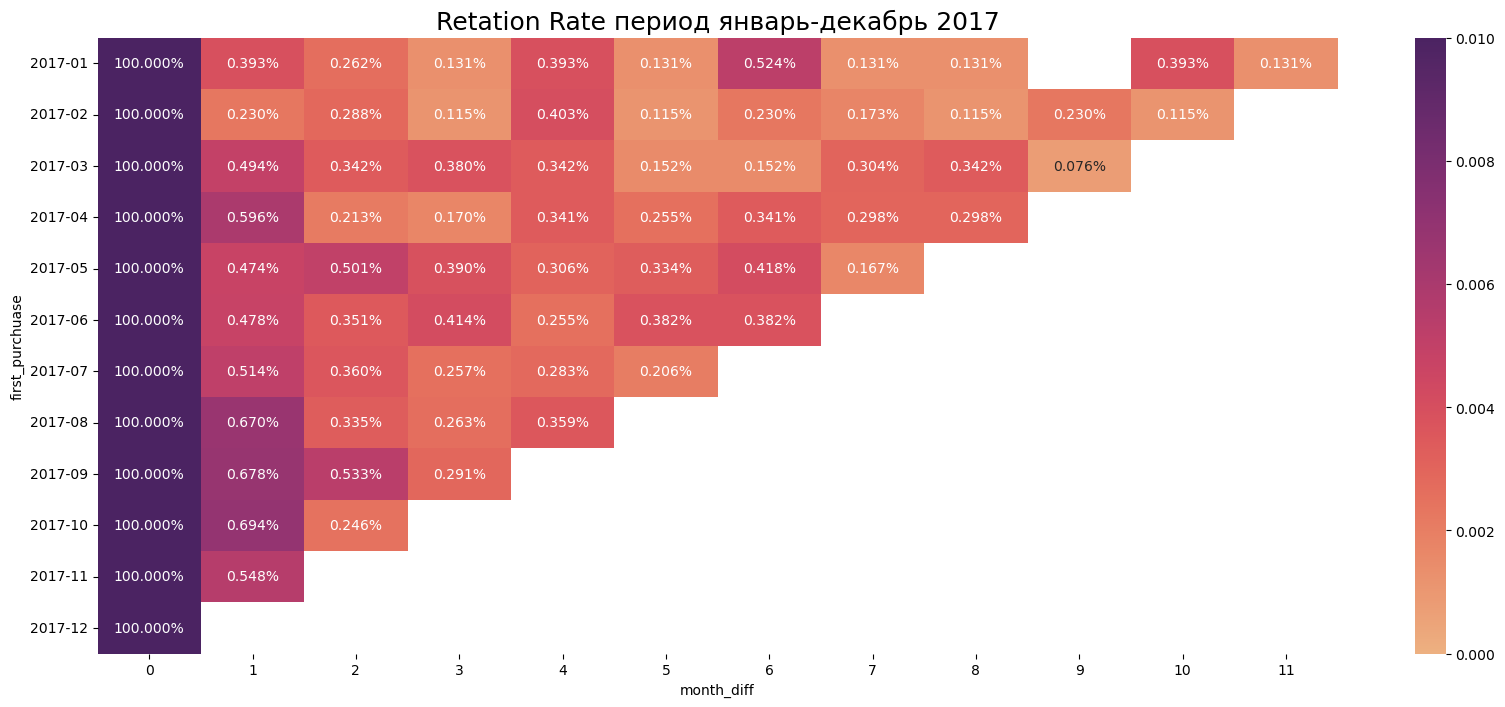

In [36]:
# визуализииурем с помощью тепловой карты для наглядности

fig, ax = plt.subplots(figsize = (20,8))
title = 'Retation Rate период январь-декабрь 2017'
plt.title(title, fontsize = 18)
ttl = ax.title
ttl.set_position([0.5, 1.05])



sns.heatmap(retantion_pivot, vmin =0.0, vmax = 0.01, cmap = "flare", annot = True, fmt = '.3%')

По тепловой карте видно, что у когорты пришедшей 2017-06 наибольший retantion rate на 3ий месяц.

### 6. Построить RFM-сегментацию пользователей.
В кластеризации можешь выбрать следующие метрики: 
- R - время от последней покупки пользователя до текущей даты, 
- F - суммарное количество покупок у пользователя за всё время, 
- M - сумма покупок за всё время. 

Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю

##### Для каждого пользователя посчитаем метрики recency, frequency и monetary

In [111]:
# посмотрим за какой период есть данные по покупкам 

print('Заказы от {} по {}'.format(orders.order_approved_at.min(),
                                    orders.order_approved_at.max()))


Заказы от 2016-09-15 12:16:38 по 2018-09-03 17:40:06


Данные доступны за период сентябрь 2016 - сентябрь 2018. Так, как RFM анализ проводится за год, установим лимит периода за последние 365 дней.

In [112]:
# установим сегодняшнюю дату для расчета Recency
now = orders.order_approved_at.max() + dt.timedelta(days = 1)
now

Timestamp('2018-09-04 17:40:06')

In [113]:
# отрежем данные за период, который нам нужен для анализа

orders.order_approved_at.max() - dt.timedelta(days = 365)
rfm_orders = orders.query('order_approved_at >= "2017-09-03 17:40:06"')

In [114]:
# создадит датафрейм с нужными для анализа данными
rfm_df = rfm_orders\
    .merge(customers, on = 'customer_id') \
     [['customer_unique_id', 'order_id', 'order_approved_at']] \
    .merge(items, on = 'order_id') \
     [['customer_unique_id', 'order_id', 'order_approved_at', 'price']] 
rfm_df.head()

,customer_unique_id,order_id,order_approved_at,price
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,29.99
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,159.90
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59,45.00
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29,19.90


In [115]:
rfm_df['days_since_order'] = rfm_df['order_approved_at'].apply(lambda x: (now - x).days) #посчитаем количество дней между сегодняшней датой и покупкой
rfm_df.head()

,customer_unique_id,order_id,order_approved_at,price,days_since_order
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,29.99,337
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,118.70,40
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,159.90,27
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59,45.00,289
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29,19.90,202


In [116]:
# посчитаем Recency и Frequency 
aggr = {
    'days_since_order': lambda x: x.min(),  # кол-во дней с последней покупки (Recency)
    'order_approved_at': lambda x: len([d for d in x if d >= now - dt.timedelta(days=365)]), # суммарное количество покупок у пользователя за всё время (Frequency)
}

rfm = rfm_df.groupby('customer_unique_id').agg(aggr).reset_index()
rfm.rename(columns={'days_since_order': 'Recency', 'order_approved_at': 'Frequency'}, inplace=True)
rfm.head()

,customer_unique_id,Recency,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1
2,0000f6ccb0745a6a4b88665a16c9f078,326,1
3,0004aac84e0df4da2b147fca70cf8255,293,1
4,0004bd2a26a76fe21f786e4fbd80607f,151,1


In [117]:
# посчитаем Monetary - сколько каждый пользователь потратил в сервисе

rfm = rfm.merge(rfm_df \
    .groupby('customer_unique_id', as_index = False) \
    .agg({"price" : 'sum'}) \
    .rename(columns = {'price' : 'Monetary'}), on = 'customer_unique_id')
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00


##### Присвоим каждому пользователю RFM баллы


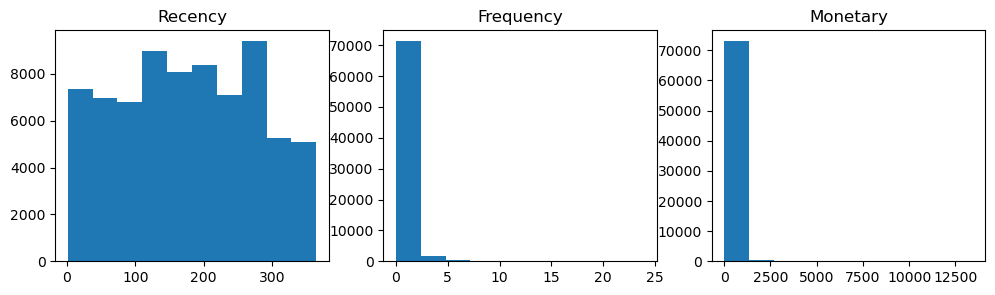

In [118]:
# Посмотрим на графики распрделения переменных Recency, Frequency и Monetary

plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.hist(rfm.Recency)
plt.title('Recency')
plt.subplot(132)
plt.hist(rfm.Frequency)
plt.title('Frequency')
plt.subplot(133)
plt.hist(rfm.Monetary)
plt.title('Monetary')


plt.show()

In [119]:
rfm.describe()

,Recency,Frequency,Monetary
count,73376.000000,73376.000000,73376.000000
mean,176.876704,1.173708,141.435597
std,98.890644,0.617186,212.950530
min,1.000000,0.000000,0.850000
25%,93.000000,1.000000,47.900000
50%,176.000000,1.000000,89.900000
75%,264.000000,1.000000,153.000000
max,365.000000,24.000000,13440.000000


In [120]:
rfm.Frequency.value_counts()

1     64459
2      6659
3      1262
4       443
5       197
6       153
0       108
7        36
8        13
9        11
10       10
12        8
11        8
14        3
13        2
18        1
20        1
24        1
15        1
Name: Frequency, dtype: int64

По графикам распределения и описательной статистике переменных видно, что более 75% покупателей совершили покупку только 1 раз, при этом покупателей, которые совершили больше 5 покупок меньшинство.
Для показателя Frequency разумно установить следующие интервалы:
- одна покупка - 1 балл
- две покупки - 2 балла
- три покупки - 3 балла
- четыре покупки - 4 балла
- пять и более покупок - 5 баллов

Для показателя Recency и Monetary будем использовать квантили, так как это непрерывные показатели.
Для Recency предпочтительнее более низкое значение, для Frequency и Monetary наоборот.

In [121]:
quantiles = rfm[['Recency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quantiles

{'Recency': {0.2: 75.0, 0.4: 143.0, 0.6: 208.0, 0.8: 279.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.99, 0.8: 179.8}}

In [122]:
def r_score(x):
    if x <= quantiles['Recency'][0.2]:
        return 5
    elif x <= quantiles['Recency'][0.4]:
        return 4
    elif x <= quantiles['Recency'][0.6]:
        return 3
    elif x <= quantiles['Recency'][0.8]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quantiles['Monetary'][0.2]:
        return 1
    elif x <= quantiles['Monetary'][0.4]:
        return 2
    elif x <= quantiles['Monetary'][0.6]:
        return 3
    elif x <= quantiles['Monetary'][0.8]:
        return 4
    else:
        return 5

def f_score(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    elif x == 4:
        return 4
    else:
        return 5

In [123]:
#присваиваем баллаы каждому пользователю

rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['Monetary'].apply(lambda x: m_score(x))

rfm['RFM'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,5,115
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,3,1,4,314


Всего получилось 5^3 = 125 сегментов. Это очень много, поэтому формируем 11 сегментов покупателей базируясь на R и F баллах. Описание сегментов:


- Чемпионы - купил недавно, покупают часто и тратят больше всего
- Лояльные клиенты - покупают на постоянной основе. реагируют рна рекламные акции
- Потенциально лояльные - недавние покупатели со средней частотой
- Новые клиенты - совершили покупку совсем недавно, но не далеют это часто 
- Подающие надежду - недавние покупатели, но не совершили много покупок
- Нуждаются во внимании - со средними показателями частоты и недавности покупок
- Неактивные, потенциально лояльные клиенты - с показателями частоты и недавности ниже среднего, потеряем, если не активируются
- В зоне риска - Покупали часто, но прошло много времени с последней покупки
- Не можем потерять - Покупали часто, но последняя покупка была давно
- Потерянные - Последняя покупка была давно, потерянные

In [130]:
segt_map = {
    r'[1-2][1-2]': 'Потерянные',
    r'[1-2][3-4]': 'В зоне риска',
    r'[1-2]5': 'Не можем потерять',
    r'3[1-2]': 'Неактивные, потенциально лояльные клиенты',
    r'33': 'Нуждаются во внимании',
    r'[3-4][4-5]': 'Лояльные клиенты',
    r'41': 'Подающие надежду',
    r'51': 'Новые клиенты',
    r'[4-5][2-3]': 'Потенциально лояльные',
    r'5[4-5]': 'Чемпионы'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,4,414,Подающие надежду
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411,Подающие надежду
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111,Потерянные
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,5,115,Потерянные
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,3,1,4,314,"Неактивные, потенциально лояльные клиенты"


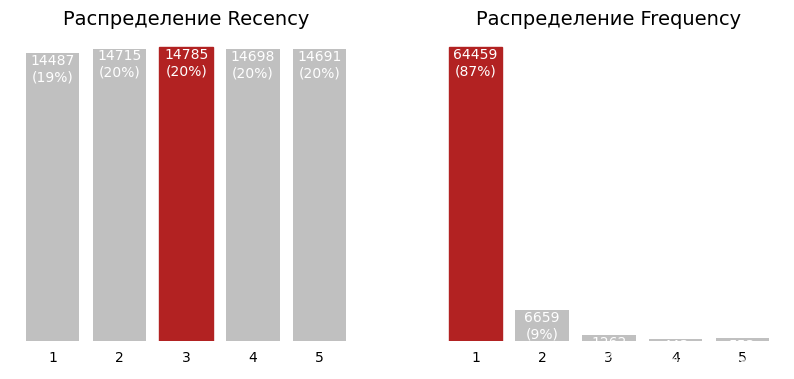

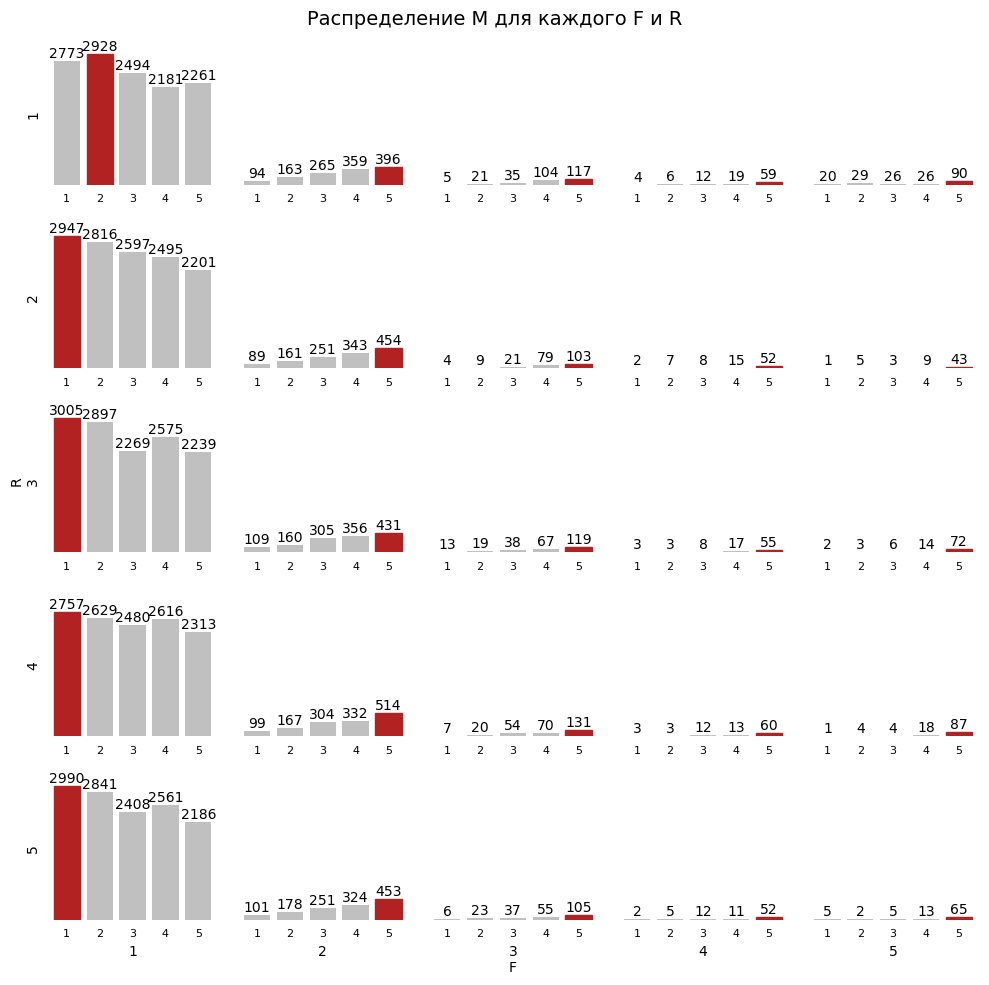

In [131]:
# визуализируем распрделение пользователей для  R и F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Распределение {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Распределение M для каждого F и R',
             fontsize=14)
plt.tight_layout()
plt.show()

Как видно из графиков распрделения - 87% покупаталей совершили покупки только 1 раз, по давности покупок покупатели распределены равномерно

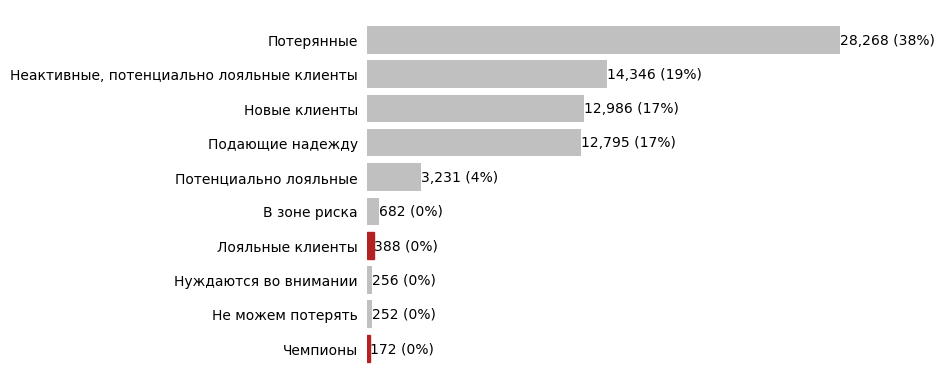

In [133]:
# посчитаем количество покупателй в каждом сегменте
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Чемпионы', 'Лояльные клиенты']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

По графику видно, что число лояльных клиентов совсем мало ( <1%). При этом очень много потерянных и неактивных клиентов клиентов. 

### Выводы и рекомендации

Были проанализированы данные о продажах в интернет магазине: проведен разведовательный анализ данных, рассчитаны разные показатели, проведен RFM и когортный анализ покупателей. На основе проведенного анализа можно сделать следующие выводы:

1. Рекомендуется изучить работу службы доставки, так как в среднем 26 заказов недоставляются по причине того, что заказы отменяются. Возможно из-за задержек доставки. 29 заказов в среднем недоставляются из-за недоступности выбранных товаров. Рекомендуется изучить работу ассортиментной матрицы, которая показывается покупателю, так как зачастую заказывают товары, которых нет в наличии.

2. Большинство пользователей (87%) сервиса совершают покупку один раз и больше не возвращаются в сервис. Рекомендуется разработать программы лояльности для удержания старых клиентов.

3. Доля лояльных клиентов сервиса очень мал, однако много новых и потенциально лояльных клиентов, рекомендуется разработать меры для работы с данным сементов клиентов для повышения лояльности.